In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.metrics import roc_auc_score
import joblib

# Cofigure tunable params

In [2]:
mu_values = np.arange(0,50)/10
plotDir = "plots/Toy/"
nBins = 10
aug_NN = False # if training NN for data augmentation instead of LDA- feature removed

In [3]:
useAuxZMeasure = False
#useAuxZMeasure = True

if useAuxZMeasure:
    plotDir = "plots/Toy/AuxMeasure/"

In [4]:
clfCol = "b"; aweCol = "g"; augCol = "y"; invCol = "r"; clfNomCol = "k"

In [5]:
n_events = n_z = 2 * 10**6 # dataset size per z
feature_std = 0.7; r = 1. 

z_nominal = np.pi/4
z_std = 0.5

n_shifts = 21
syst_shifts = np.arange(0,21)/10 # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]
assert len(syst_shifts)==n_shifts
z_syst =  z_nominal * syst_shifts
systUp = z_nominal * syst_shifts[-1]

# TF GPU settings

In [6]:
onlyCPU = False
onlyCPU = True


import os
import tensorflow as tf

if onlyCPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2023-05-19 16:17:03.744193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 16:17:04.055282: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-19 16:17:04.055340: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid005876): /proc/driver/nvidia/version does not exist


# Generate Dataset

In [7]:
X_sig_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T 
              for i in range (n_shifts)])
Y_sig_syst = np.array([np.ones(n_events) for i in range (n_shifts)])
centres_sig_syst = np.array([r* np.vstack([np.cos(z_syst[i]), np.sin(z_syst[i])]).T for i in range(n_shifts)])
X_sig_syst += centres_sig_syst

X_back_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T
                        for i in range (n_shifts)])
Y_back_syst = np.array([np.zeros(n_events) for i in range (n_shifts)])
centres_back_syst = np.array([r* np.vstack([-np.cos(z_syst[i]), -np.sin(z_syst[i])]).T for i in range(n_shifts)])
X_back_syst += centres_back_syst

X_syst = np.concatenate([X_sig_syst,X_back_syst], 1)
Y_syst = np.hstack([Y_sig_syst,Y_back_syst])
Z_syst  = np.ones_like(Y_syst) * z_syst.reshape(-1,1)

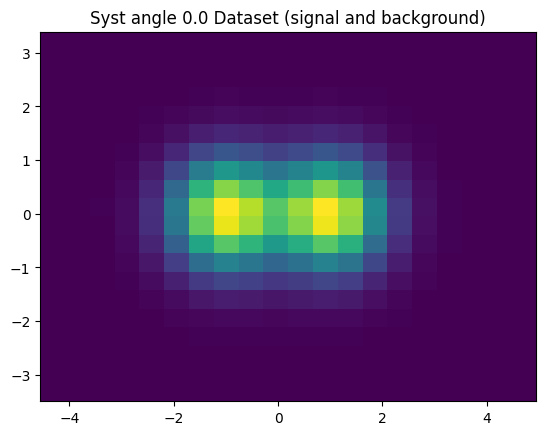

In [8]:
plt.hist2d(X_syst[0,:,0], X_syst[0,:,1], bins=20)
plt.title("Syst angle {} Dataset (signal and background)".format(np.round(z_syst[0],2)))
#plt.savefig(plotDir + "systDown_dataset.pdf")
plt.show()

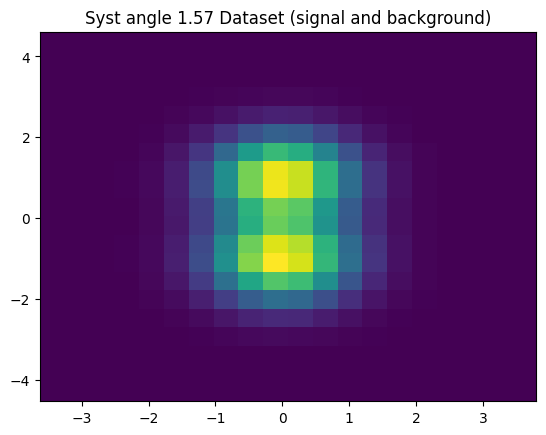

In [9]:
plt.hist2d(X_syst[-1,:,0], X_syst[-1,:,1], bins=20)
plt.title("Syst angle {} Dataset (signal and background)".format(np.round(z_syst[-1],2)))
#plt.savefig(plotDir + "systUp_dataset.pdf")
plt.show()

In [10]:
X_syst = X_syst.reshape(-1,X_syst.shape[-1])
Y_syst = Y_syst.reshape(-1)
Z_syst = Z_syst.reshape(-1)

## Shuffle and split train test

In [11]:
from sklearn.model_selection import train_test_split
X_syst_train, X_syst_test, Y_syst_train, Y_syst_test, Z_syst_train, Z_syst_test  = train_test_split(X_syst,Y_syst,Z_syst, shuffle=True)
print(X_syst_train.shape, X_syst_test.shape, Y_syst_train.shape, Y_syst_test.shape, Z_syst_train.shape, Z_syst_test.shape)

(63000000, 2) (21000000, 2) (63000000,) (21000000,) (63000000,) (21000000,)


## Save Load datasets

## Calc indices

In [12]:
systUpEvents = np.isclose(Z_syst_test, systUp)
nominalEvents = np.isclose(Z_syst_test, z_nominal)

## Contour plot of data

/tmp/ipykernel_248736/1013750649.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which="major")


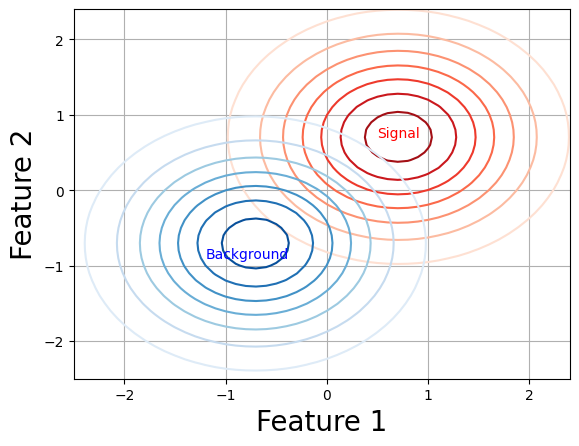

In [13]:
from scipy.stats import multivariate_normal

# Contour plots
lims = 2.5
x, y = np.mgrid[-lims:lims:.1, -lims:lims:.1]
pos = np.dstack((x, y))
signal_pdf = multivariate_normal([np.cos(np.pi/4), np.sin(np.pi/4)], [[0.7, 0], [0, 0.7]])
back_pdf = multivariate_normal([-np.cos(np.pi/4), -np.sin(np.pi/4)], [[0.7, 0], [0, 0.7]])
plt.contour(x, y, signal_pdf.pdf(pos), cmap="Reds")
plt.text(0.5,0.7, "Signal", color="Red")
plt.contour(x, y, back_pdf.pdf(pos), cmap="Blues")
plt.text(-1.2,-0.9, "Background", color="Blue")
plt.grid(b=True, which="major")

plt.xlabel("Feature 1", fontsize="20")
plt.ylabel("Feature 2", fontsize="20")


#plt.savefig(plotDir + "Toy_Nominal_Dataset_Countour.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

# Train/Define Models

## Clf on Nominal

In [14]:
class nominalModel:
    def predict(self,X):
        from scipy.stats import multivariate_normal
        angle = np.pi/4
        rv_signal = multivariate_normal((np.cos(angle),np.sin(angle)),(feature_std,feature_std)).pdf
        rv_back = multivariate_normal((-np.cos(angle),-np.sin(angle)),(feature_std,feature_std)).pdf
        score = rv_signal(X)/(rv_signal(X) + rv_back(X))
        return score
nominal_model = nominalModel()

In [15]:
Y_predict_nomOnSys = nominal_model.predict(X_syst_test[systUpEvents]).reshape(-1)
Y_predict_nomOnnom = nominal_model.predict(X_syst_test[nominalEvents]).reshape(-1)

In [16]:
print ("Test AUC nom on nom: ", roc_auc_score(y_true=Y_syst_test[nominalEvents], y_score=Y_predict_nomOnnom))
print ("Test AUC nom on syst: ", roc_auc_score(y_true=Y_syst_test[systUpEvents], y_score=Y_predict_nomOnSys ))

Test AUC nom on nom:  0.978493412575758
Test AUC nom on syst:  0.923797537688873


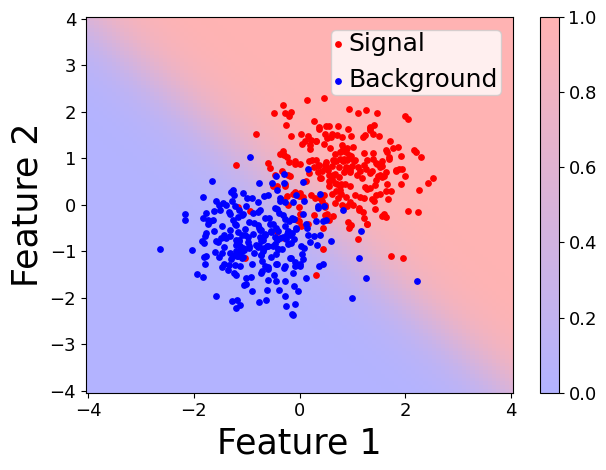

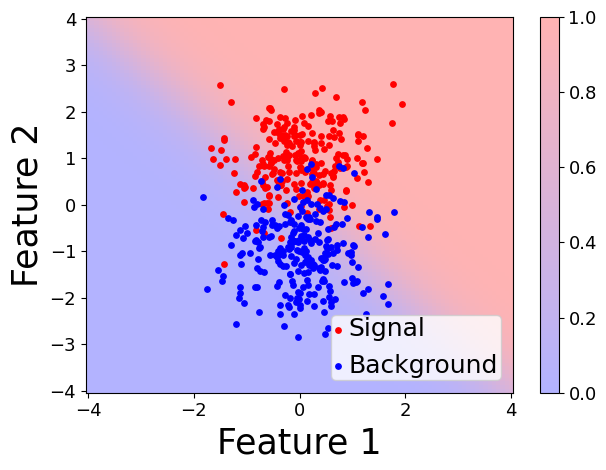

In [17]:
def decisionFuncPlot(model, clfName, z_val=z_nominal):
    #plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=25)     # fontsize of the axes title
    plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
    plt.rc('legend', fontsize=18)    # legend fontsize
    plt.rcParams.update({'figure.autolayout': True})


    zval_Events = np.isclose(Z_syst_test, z_val)
    # Colormap
    cmap = colors.LinearSegmentedColormap(
        'red_blue_classes',
        {'red': [(0, 1, 1), (1, 0.7, 0.7)],
         'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
         'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
    try:
        plt.cm.register_cmap(cmap=cmap)
    except:
        pass
    color_map = plt.cm.get_cmap('red_blue_classes')
    cmap_reversed = cmap.reversed() # red for 1 blue for 0 instead

    # class 0 and 1 : areas
    nx, ny = 100, 100
    x_min, x_max = -4,4
    y_min, y_max = -4,4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
    if clfName == "Aware":
        Z = model.predict([np.c_[xx.ravel(), yy.ravel()],(z_val)*np.ones(len(xx.ravel()))])
    elif (clfName == "Nominal") or (clfName == "Invariant") or (clfName == "Up"):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    elif clfName == "Augmented":
        if aug_NN:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        
    Z = Z.reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, Z, cmap=cmap_reversed,
               norm=colors.Normalize(0., 1.), zorder=0)
    cbar = plt.colorbar()
    ppc = 250 # scatter points per class
    s = 15.
    plt.scatter(X_syst_test[zval_Events & (Y_syst_test==1)][:ppc,0], X_syst_test[zval_Events & (Y_syst_test==1)][:ppc,1],
                color="red", s=s,label="Signal")
    plt.scatter(X_syst_test[zval_Events & (Y_syst_test==0)][:ppc,0], X_syst_test[zval_Events & (Y_syst_test==0)][:ppc,1],
                color="blue", s=s, label="Background")

    #plt.title("Decision Function of {} Classifier on Z={}".format(clfName, np.round(z_val,2)))
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(borderpad=0.1, handlelength=0.3, handletextpad=0.3)
    plt.tight_layout()
#     plt.savefig(plotDir+"DecisionFunction_{}_on_Z{}.pdf".format(clfName, np.round(z_val,2)),
#                 bbox_inches='tight',pad_inches = 0)
    plt.show()



decisionFuncPlot(model=nominal_model, clfName="Nominal", z_val=z_nominal)
decisionFuncPlot(model=nominal_model, clfName="Nominal", z_val=systUp)

## Train Data Augmented Model

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
augmented_model = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

In [19]:
#train model
augmented_model.fit(X_syst_train, Y_syst_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [20]:
Y_predict_augOnSys = augmented_model.predict_proba(X_syst_test[np.isclose(Z_syst_test, systUp)])[:,1].reshape(-1)

In [21]:
print ("Test AUC Aug on Syst: ",roc_auc_score(y_true=Y_syst_test[np.isclose(Z_syst_test, systUp)], y_score=Y_predict_augOnSys ))

Test AUC Aug on Syst:  0.9238089543018582


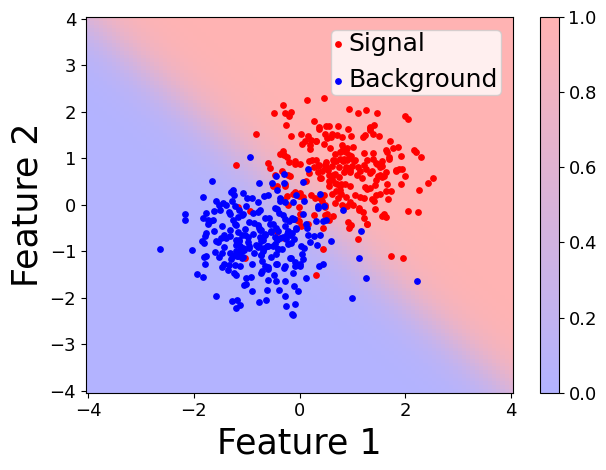

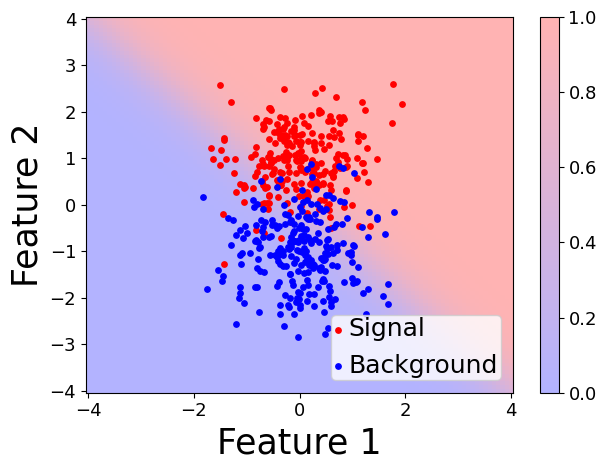

In [22]:
decisionFuncPlot(model=augmented_model, clfName="Augmented", z_val=z_nominal)
decisionFuncPlot(model=augmented_model, clfName="Augmented", z_val=systUp)

## Syst Aware Model

In [23]:
class awareModel:
    def predict(self,inputs):
        X, angle = inputs[0], inputs[1]
        from scipy.stats import multivariate_normal
        angle = np.array(angle)
        assert (angle == angle[0]).all()
        angle = angle[0]
        rv_signal = multivariate_normal((np.cos(angle),np.sin(angle)),(feature_std,feature_std)).pdf
        rv_back = multivariate_normal((-np.cos(angle),-np.sin(angle)),(feature_std,feature_std)).pdf
        score = rv_signal(X)/(rv_signal(X) + rv_back(X))
        return score
aware_model = awareModel()

In [24]:
Y_predict_AweOnSys = aware_model.predict([X_syst_test[systUpEvents], Z_syst_test[systUpEvents]]).reshape(-1)
Y_predict_AweIfNom = aware_model.predict([X_syst_test[systUpEvents], z_nominal* np.ones_like(Z_syst_test[systUpEvents])]).reshape(-1)
Y_predict_AweOnNom = aware_model.predict([X_syst_test[nominalEvents], z_nominal* np.ones(nominalEvents.sum())]).reshape(-1)
Y_predict_AweIfSys = aware_model.predict([X_syst_test[nominalEvents], systUp* np.ones(nominalEvents.sum())]).reshape(-1)

In [25]:
print ("Test AUC Awe on Nom: ",roc_auc_score(y_true=Y_syst_test[nominalEvents], y_score=Y_predict_AweOnNom ))
print ("Test AUC Awe on Syst: ",roc_auc_score(y_true=Y_syst_test[systUpEvents], y_score=Y_predict_AweOnSys ))

Test AUC Awe on Nom:  0.978493412575758
Test AUC Awe on Syst:  0.9783858265670303


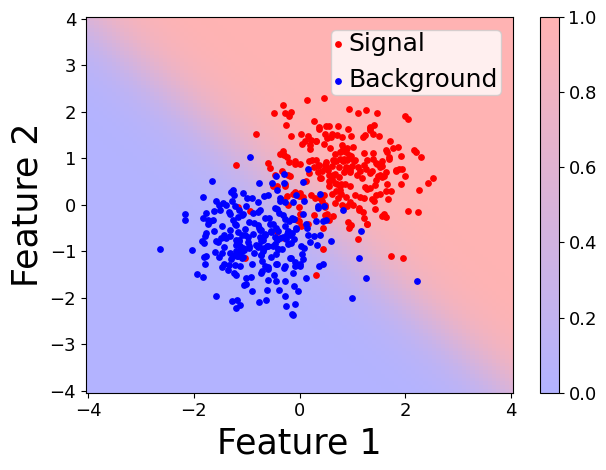

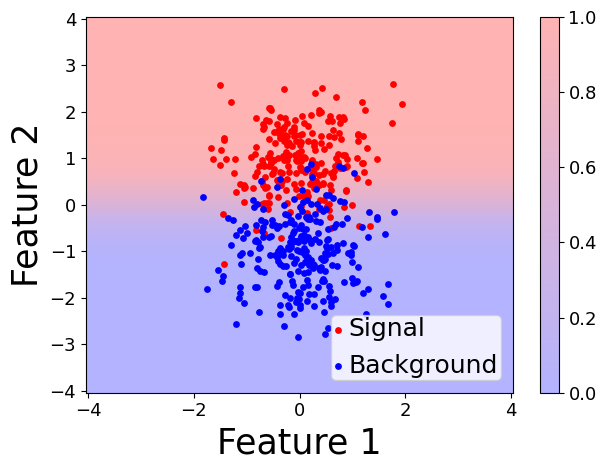

In [26]:
decisionFuncPlot(model=aware_model, clfName="Aware", z_val=z_nominal)
decisionFuncPlot(model=aware_model, clfName="Aware", z_val=systUp)

## Train Pivot

In [27]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from gradRevLayer import GradReverseTR as GradReverse

n_hidden_inv = 10; n_hidden_inv_R = 10
n_nodes_inv = 64; n_nodes_inv_R = 64
hp_lambda = 1.

inputs = Input(shape=(X_syst_train.shape[1],))

Dx = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv -1):
    Dx = Dense(n_nodes_inv, activation='relu', kernel_regularizer='l2')(Dx)
Dx = Dense(1, activation="sigmoid", name="Clf")(Dx)
inv_model = Model(inputs=inputs, outputs=Dx)

GRx = GradReverse()(Dx)
Rx = Dense(n_nodes_inv_R, activation="relu")(GRx)
for i in range(n_hidden_inv_R -1):
    Rx = Dense(n_nodes_inv_R, activation='relu', kernel_regularizer='l2')(Rx)
#Rx = Dense(1, activation="sigmoid")(Rx)
Rx = Dense(1, activation="linear", name="Adv")(Rx)
GR = Model(inputs=inputs, outputs=[Dx, Rx])

GR.compile(loss=["binary_crossentropy", "mean_squared_error"], loss_weights=[1,hp_lambda], optimizer="RMSProp")

#### reduced epochs for fast demo

In [28]:
n_epochs = 1 # 100 
GR.fit(x=X_syst_train, y=[Y_syst_train, Z_syst_train], epochs=n_epochs, batch_size=4*1024)

15381/15381 [==============================] - 181s 12ms/step - loss: 0.5781 - Clf_loss: 0.2558 - Adv_loss: 0.2264


In [29]:
Y_predict_InvOnSys = inv_model.predict(X_syst_test[systUpEvents], batch_size=4*1024).reshape(-1)
Y_predict_InvOnNom = inv_model.predict(X_syst_test[nominalEvents], batch_size=4*1024).reshape(-1)

244/244 [==============================] - 1s 3ms/step


In [30]:
#print ("Train AUC Awe on Aug: ", roc_auc_score(y_true=Y_test, y_score=Y_predict_AweOnAug))
print ("Test AUC Inv on Nom: ",roc_auc_score(y_true=Y_syst_test[nominalEvents], y_score=Y_predict_InvOnNom ))
print ("Test AUC Inv on Syst: ",roc_auc_score(y_true=Y_syst_test[systUpEvents], y_score=Y_predict_InvOnSys ))

Test AUC Inv on Nom:  0.9784920151334663
Test AUC Inv on Syst:  0.9230605272622496


313/313 [==============================] - 0s 483us/step


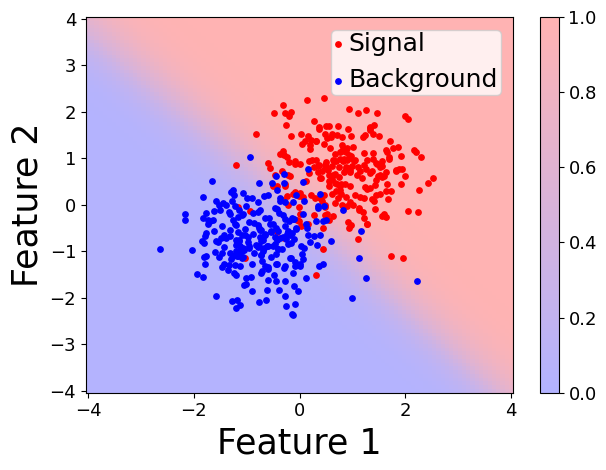

313/313 [==============================] - 0s 460us/step


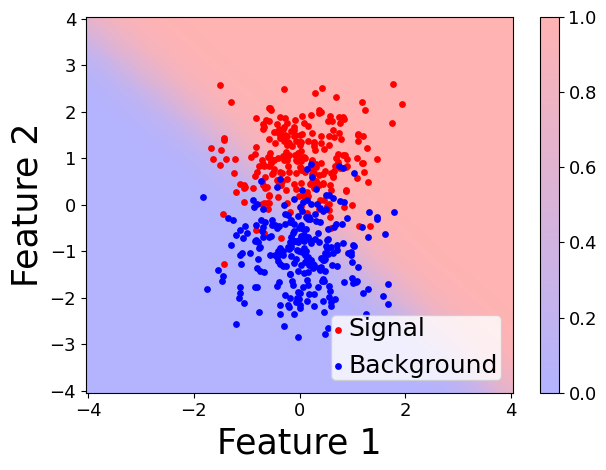

In [31]:
decisionFuncPlot(model=inv_model, clfName="Invariant", z_val=z_nominal)
decisionFuncPlot(model=inv_model, clfName="Invariant", z_val=systUp)

#  Likelihoods

In [32]:
def nll_stat(N,S,B,mu):
    from scipy.special import loggamma
    nexp=mu*S+B
    nll_stat = - (N* np.log(nexp) - nexp - loggamma(N) ) # Poisson
    if np.isinf(nll_stat):
        print (N, nexp)
    return nll_stat

def nll_syst(dTheta, sigma=1):
    nll_syst = - (np.log (1/(sigma*np.sqrt(2*np.pi))) + (-0.5 * (dTheta/sigma)**2))
    return nll_syst

def nll_aux(N,B):
    from scipy.special import loggamma
    nexp=B
    nll_stat = - (N* np.log(nexp) - nexp - loggamma(N) ) # Poisson
    return nll_stat

In [33]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 
weights_syst = np.ones_like(Y_syst_test)
weights_syst[Y_syst_test==1] *=sigScaling
weights_syst[Y_syst_test==0] *=backScaling


# Build Aux data

In [34]:
if useAuxZMeasure:
    aux_std = 0.5; n_aux = 10**5; aux_hist_range=(-1,2.5)
    weight_aux = 1/10. * np.ones(n_aux)
    aux_hists = []
    nBinsAux = 4
    for z_val in z_syst:
        hist_aux, bin_array_aux = np.histogram(
            np.random.normal(z_val, aux_std, n_aux), 
            weights=weight_aux, range=aux_hist_range, bins=nBinsAux)
        aux_hists.append(hist_aux)
    aux_hists = np.array(aux_hists) 
    # always exacty same number of events unlike with train-test split

In [35]:
if useAuxZMeasure:
    nominal_aux_events = np.where(z_syst==z_nominal)[0][0]
    systUp_aux_events = np.where(z_syst==systUp)[0][0]

# Building templates, 2D NLL

In [36]:
def buildTemplates(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    for z_val in z_syst:
        zEvents = np.isclose(Z_syst_test, z_val)
        if (clfName == "Aware"):
            print ("Not Currently Supported for analyticial aware classifier")
            Y_pred_model = model.predict([X_syst_test,Z_syst_test]).reshape(-1)
        elif (clfName == "Invariant"):
            Y_pred_model = model.predict(X_syst_test, batch_size=4000).reshape(-1)
        elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
            if (clfName == "Augmented") and (~aug_NN):
                Y_pred_model = model.predict_proba(X_syst_test)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_test).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
            
        hist_sig, bin_array = np.histogram(
            Y_pred_model[zEvents &(Y_syst_test==1)], 
            weights=weights_syst[zEvents &(Y_syst_test==1)], range=(0,1), bins=nBins)
        hist_back, bin_array = np.histogram(
            Y_pred_model[zEvents &(Y_syst_test==0)], 
            weights=weights_syst[zEvents &(Y_syst_test==0)], range=(0,1), bins=nBins)
            
        sig_hists.append(hist_sig)
        back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists

In [37]:
def computeNLL2D(obs1D, sH2d, bH2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D


In [38]:
def computeNLL2D_aux(obs1D, obsAux1D, sH2d, bH2d, expAux2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    assert len(obsAux1D) == expAux2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst):
        for nn,bb in zip(obsAux1D,expAux2d[i]):
            bin_nll_aux = nll_aux(N=nn,B=bb)
            if (not np.isnan(bin_nll_aux)):
                nll2D[:,i] += bin_nll_aux

        for k,mu in enumerate(mu_values):
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

In [39]:
def plotNLLCurves(x, y_list, label_list, color_list, linestyle_list, testDataLabel, 
                  xlim=[0.3, 1.8], ylim=[0,10],
                  ylimRatio=[0.8, 1.2], legendOrder=None, showLegend=True):
    # assumes last y is reference
    ref_y = y_list[-1]
    
    if showLegend:
        fig = plt.figure(figsize=(5, 15/4)) 
    else:
        fig = plt.figure(figsize=(5, 3)) 
    ax0 = plt.subplot()
    
   
    for (y, lab, col, ls) in zip(y_list, label_list, color_list, linestyle_list):
        ax0.plot(x,y, label=lab, color=col, linestyle=ls)
    ax0.set_ylim(ylim)
    ax0.set_xlim(xlim)
    if showLegend:
        if (legendOrder is None):
            plt.legend(prop={'size': 10}, loc="lower right")
        else:
            handles, labels = ax0.get_legend_handles_labels()
            # re-order and legend in one step
            ax0.legend([handles[i] for i in legendOrder], [labels[i] for i in legendOrder], 
                       prop={'size': 14.38}, loc=(-0.15,1.04), handletextpad=0.1, borderpad=0.12,
                      handlelength=1, ncol=2 ) 
    plt.xlabel(r'$\mu$', fontsize=15)
    plt.ylabel(r'NLL - min(NLL)', fontsize=15)
    plt.tight_layout()

# Evaluate Models

## Baseline Classifier (trained on Nominal only)

In [40]:
sig_hists, back_hists = buildTemplates(model=nominal_model, clfName="Nominal")

In [41]:
def createHistObs(X, weights, model,):
    Y = model.predict(X,).reshape(-1)
    hist_obs, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
    return hist_obs, bin_array

In [42]:
hist_obs, bin_array = createHistObs(X=X_syst_test[nominalEvents], weights=weights_syst[nominalEvents], 
              model=nominal_model)

In [43]:
if useAuxZMeasure:
    nll2D_clf_nom = computeNLL2D_aux(obs1D=hist_obs,  sH2d=sig_hists, bH2d=back_hists,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_clf_nom = computeNLL2D(obs1D=hist_obs, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 0.7853981633974483


In [44]:
def plot2dNLL(nll2D, dataName, clfName):
    xx, yy = np.meshgrid(mu_values,z_syst)
    ind = np.unravel_index(np.argmin(nll2D, axis=None), nll2D.shape)
    plt.pcolormesh(xx,yy,(nll2D-nll2D.min() + 1).T,)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r"NLL", labelpad=0)
    cbar.ax.set_ylabel(r"NLL - min(NLL) + 1", labelpad=5, size=15)
    cbar.formatter.set_powerlimits((0, 0))
    plt.scatter(mu_values[ind[0]],z_syst[ind[1]] , color="crimson", s=200)
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$z$")

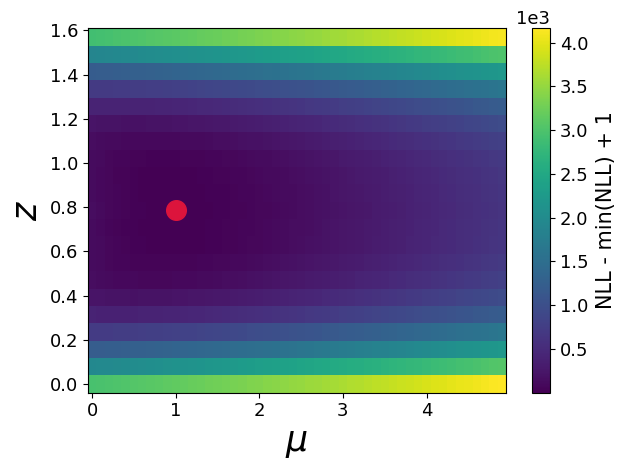

In [45]:
plot2dNLL(nll2D=nll2D_clf_nom, dataName="Nominal", clfName="Clf")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Clf", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [46]:
nll1D_clf_nom = nll2D_clf_nom.min(axis=1)

In [47]:
hist_obs_systUp, bin_array = createHistObs(X=X_syst_test[systUpEvents], weights=weights_syst[systUpEvents], 
              model=nominal_model)

In [48]:
nll2D_clf_systUp = computeNLL2D(obs1D=hist_obs_systUp, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 1.5707963267948966


In [49]:
if useAuxZMeasure:
    nll2D_clf_systUp = computeNLL2D_aux(obs1D=hist_obs_systUp,  sH2d=sig_hists, bH2d=back_hists,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_clf_systUp = computeNLL2D(obs1D=hist_obs_systUp, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 1.5707963267948966


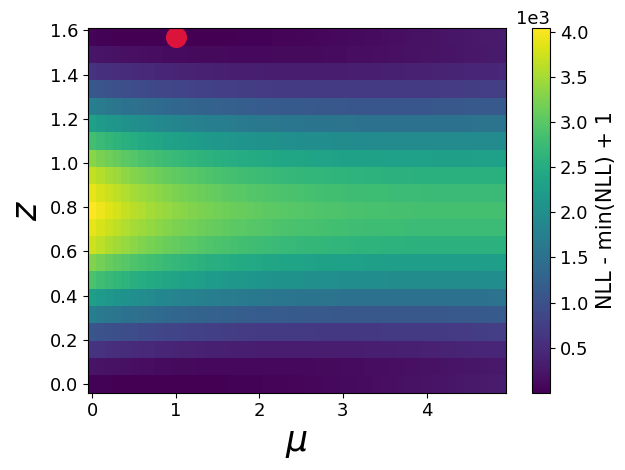

In [50]:
plot2dNLL(nll2D=nll2D_clf_systUp, dataName="SystUp", clfName="Clf")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Clf", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [51]:
nll1D_clf_systUp = nll2D_clf_systUp.min(axis=1)

### Show templates

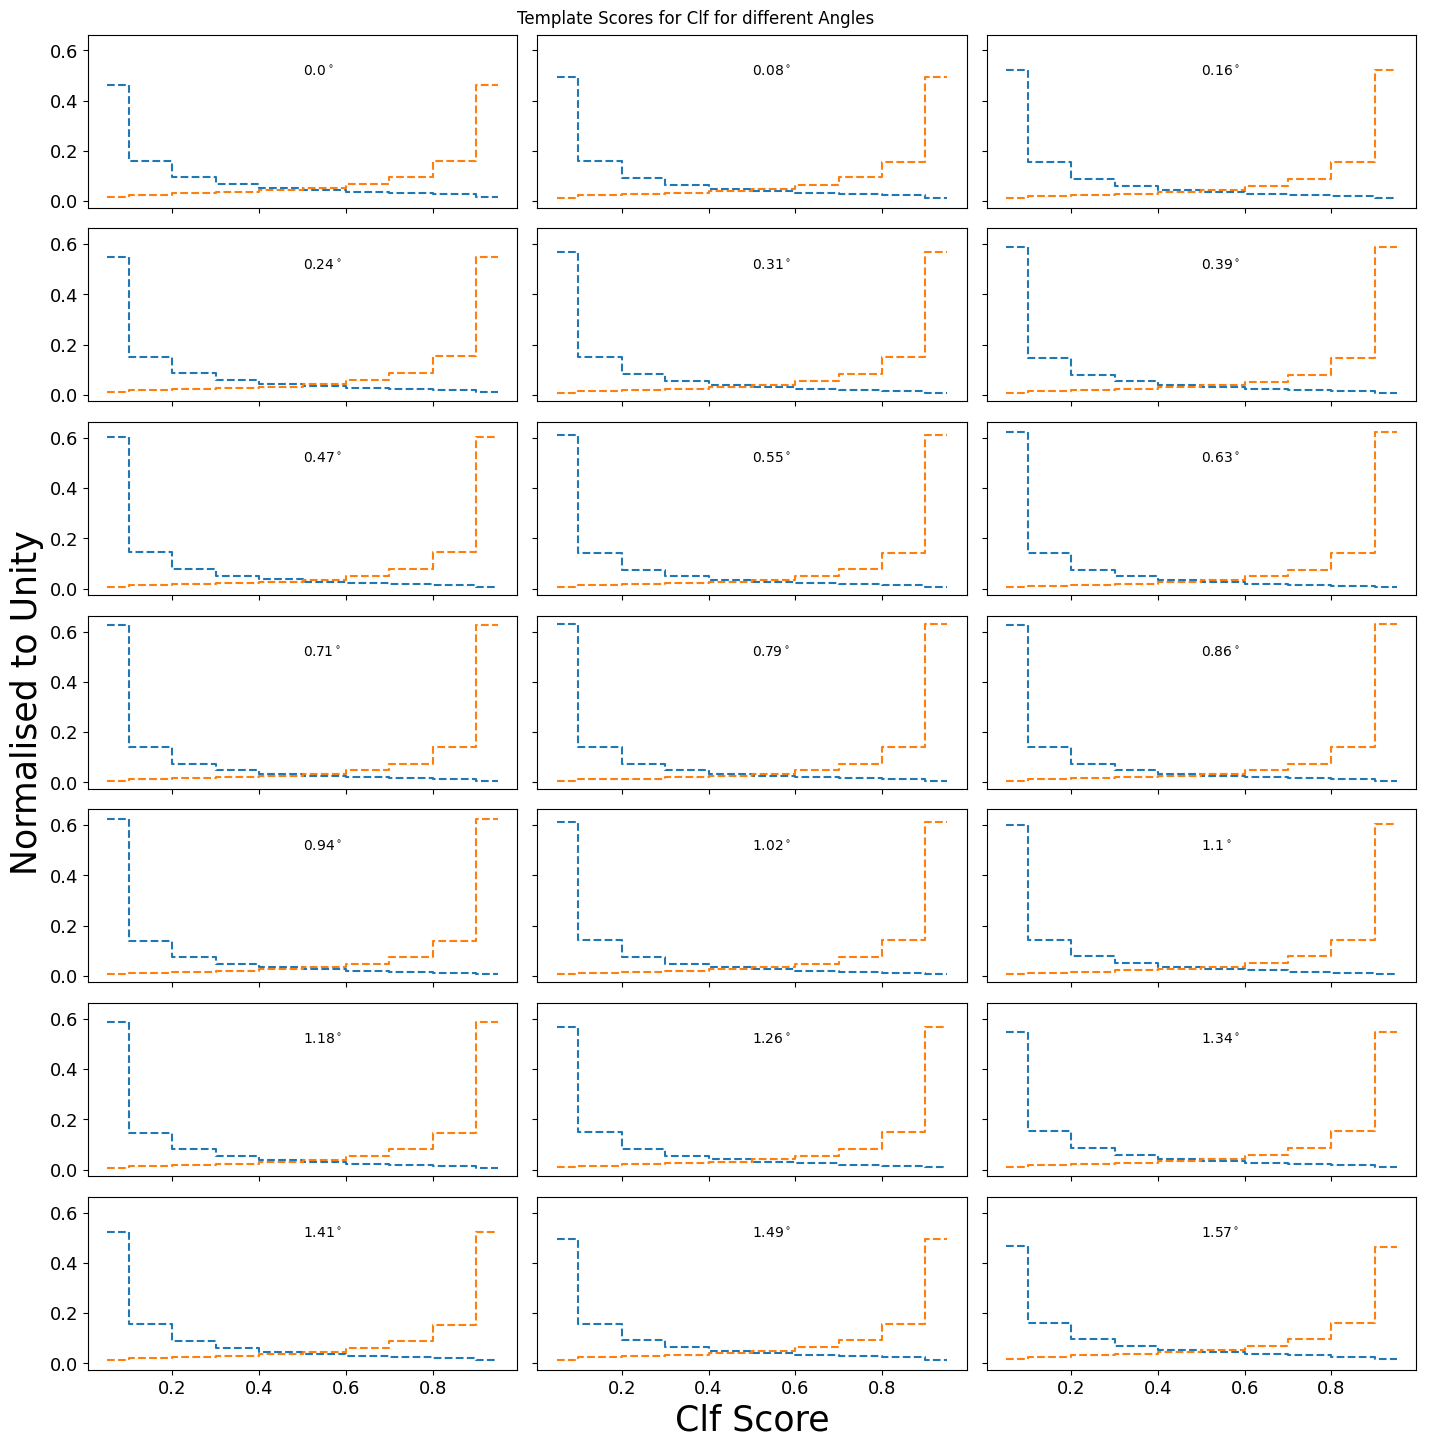

In [52]:
def show_templates(sHists,bHists,clfName):
    bincentres = [(bin_array[i]+bin_array[i+1])/2. for i in range(len(bin_array)-1)]
    fig, axs = plt.subplots(7, 3,sharex=True, sharey=True, figsize=(15,15))
    fig.add_subplot(111, frameon=False)
    for i in range(sHists.shape[0]):
        axs[i//3,i%3].step(bincentres,bHists[i,:]/bHists[i,:].sum(),where='mid',linestyle='--', label="Signal")
        axs[i//3,i%3].step(bincentres,sHists[i,:]/sHists[i,:].sum(),where='mid',linestyle='--', label="Background")
        axs[i//3,i%3].text(0.5,0.5,r"{}$^\circ$".format(np.round(z_syst,2)[i]))
        #axs[i%7,i%3].legend()
        #axs[i%7,i%3].set_title("Template Scores for Clf using Dataset with Angle {}".format(np.round(z_syst,2)[i]))
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Normalised to Unity")
    plt.xlabel("{} Score".format(clfName))
    plt.suptitle("Template Scores for {} for different Angles".format(clfName))

show_templates(sHists=sig_hists,bHists=back_hists,clfName="Clf")
#plt.savefig(plotDir+"TemplateHist_Clf_syst.pdf")
plt.show()
    
    

## Data Augmentation trained classifier

In [53]:
sig_hists_aug, back_hists_aug = buildTemplates(model=augmented_model, clfName="Augmented")

In [54]:
hist_obs_aug, bin_array = np.histogram(
    augmented_model.predict_proba(X_syst_test[nominalEvents])[:,1].reshape(-1), 
    weights=weights_syst[nominalEvents], range=(0,1), bins=nBins)


In [55]:
if useAuxZMeasure:
    nll2D_aug_nom = computeNLL2D_aux(obs1D=hist_obs_aug, sH2d=sig_hists_aug, bH2d=back_hists_aug,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_aug_nom = computeNLL2D(obs1D=hist_obs_aug, sH2d=sig_hists_aug, bH2d=back_hists_aug)

nll1D_aug_nom = nll2D_aug_nom.min(axis=1)

Min at mu,z:  1.0 0.7853981633974483


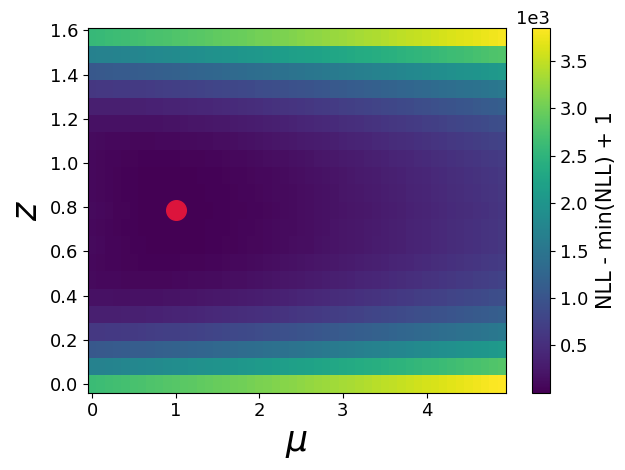

In [56]:
plot2dNLL(nll2D=nll2D_aug_nom, dataName="Nominal", clfName="Aug")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Aug", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [57]:
hist_obs_aug_systUp, bin_array = np.histogram(
        augmented_model.predict_proba(X_syst_test[systUpEvents])[:,1].reshape(-1), 
        weights=weights_syst[systUpEvents], range=(0,1), bins=nBins)

In [58]:
if useAuxZMeasure:
    nll2D_aug_systUp = computeNLL2D_aux(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_aug_systUp = computeNLL2D(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug)

nll1D_aug_systUp = nll2D_aug_systUp.min(axis=1)

Min at mu,z:  1.0 1.5707963267948966


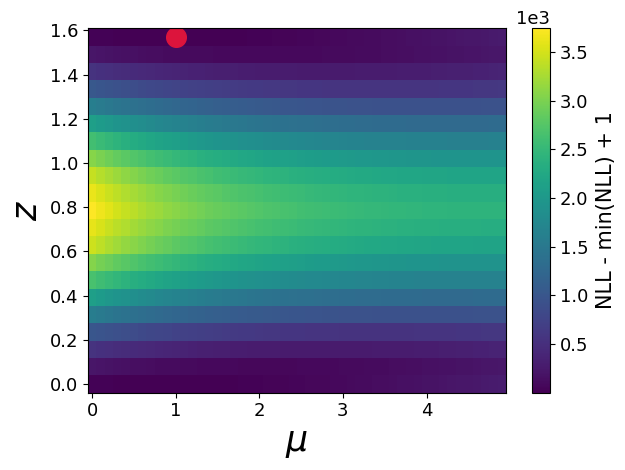

In [59]:
plot2dNLL(nll2D=nll2D_aug_systUp, dataName="SystUp", clfName="Aug")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Aug", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

## Syst Aware classifier

In [60]:
# Build templates

nBins = 10
sig_hists_awe = []
back_hists_awe = []
for z_val in z_syst:
    systEvents = np.isclose(Z_syst_test, z_val)
    hist_sign_awe, bin_array = np.histogram(
        aware_model.predict([X_syst_test[systEvents],Z_syst_test[systEvents]]).reshape(-1)[Y_syst_test[systEvents]==1], 
        weights=weights_syst[systEvents][Y_syst_test[systEvents]==1], range=(0,1), bins=nBins)
    hist_back_awe, bin_array = np.histogram(
        #FixMe no need to do the prediction twice
        aware_model.predict([X_syst_test[systEvents],Z_syst_test[systEvents]]).reshape(-1)[Y_syst_test[systEvents]==0], 
        weights=weights_syst[systEvents][Y_syst_test[systEvents]==0], range=(0,1), bins=nBins)
    sig_hists_awe.append(hist_sign_awe)
    back_hists_awe.append(hist_back_awe)
sig_hists_awe = np.array(sig_hists_awe)
back_hists_awe = np.array(back_hists_awe)
    

In [61]:
def createHistObsAwe(X, weights):
    hist_obs_awe2D = []
    for hyp_z in z_syst:
        Y = aware_model.predict([X, np.ones(X.shape[0]) * hyp_z],).reshape(-1)
        hist_obs_awe, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
        hist_obs_awe2D.append(hist_obs_awe)
    hist_obs_awe2D = np.array(hist_obs_awe2D)
    return hist_obs_awe2D

In [62]:
hist_obs_awe2D = createHistObsAwe(X=X_syst_test[nominalEvents], weights=weights_syst[nominalEvents])

In [63]:
def computeNLL2D_aware(obs2D, sH2d, bH2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std) # @ToDo: can be moved outside loop
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

def computeNLL2D_aware_aux(obs2D, obsAux1D, sH2d, bH2d, expAux2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    assert len(obsAux1D) == expAux2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst):
        for nn,bb in zip(obsAux1D,expAux2d[i]):
            bin_nll_aux = nll_aux(N=nn,B=bb)
            if (not np.isnan(bin_nll_aux)):
                nll2D[:,i] += bin_nll_aux
        for k,mu in enumerate(mu_values):
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo - different from computeNLL2D()
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

In [64]:
if useAuxZMeasure:
    nll2D_awe_nom = computeNLL2D_aware_aux(obs2D=hist_obs_awe2D, sH2d=sig_hists_awe, bH2d=back_hists_awe,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_awe_nom = computeNLL2D_aware(obs2D=hist_obs_awe2D, sH2d=sig_hists_awe, bH2d=back_hists_awe)
    
nll1D_awe_nom = nll2D_awe_nom.min(axis=1)

Min at mu,z:  1.0 0.7853981633974483


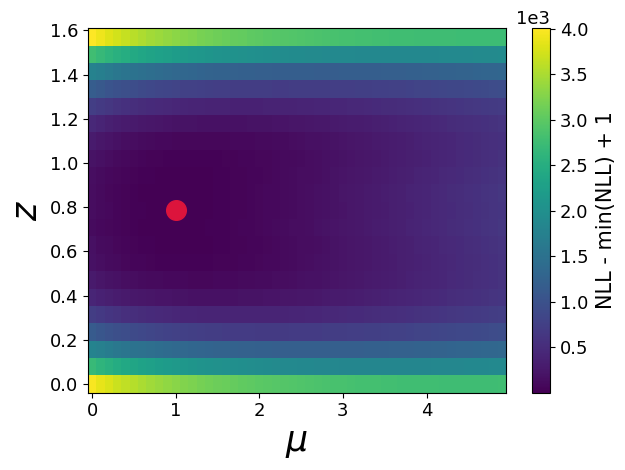

In [65]:
plot2dNLL(nll2D=nll2D_awe_nom, dataName="Nominal", clfName="Awe")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Awe", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [66]:
hist_obs_awe2D_systUp = createHistObsAwe(X=X_syst_test[systUpEvents], 
                            weights=weights_syst[systUpEvents])

In [67]:
if useAuxZMeasure:
    nll2D_awe_systUp = computeNLL2D_aware_aux(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_awe_systUp = computeNLL2D_aware(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe)

Min at mu,z:  1.0 1.5707963267948966


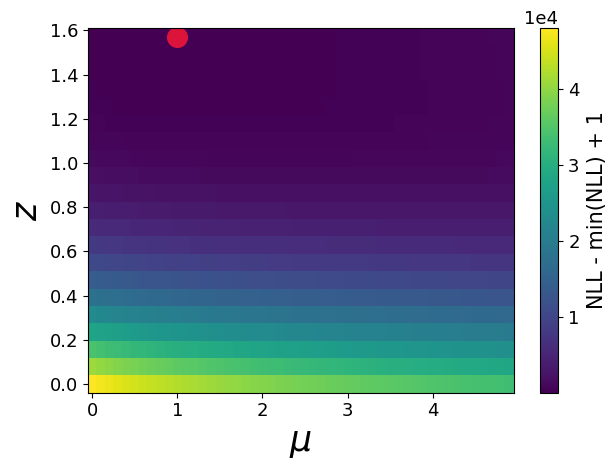

In [68]:
plot2dNLL(nll2D=nll2D_awe_systUp, dataName="SystUp", clfName="Awe")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Awe", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [69]:
nll1D_awe_systUp = nll2D_awe_systUp.min(axis=1)

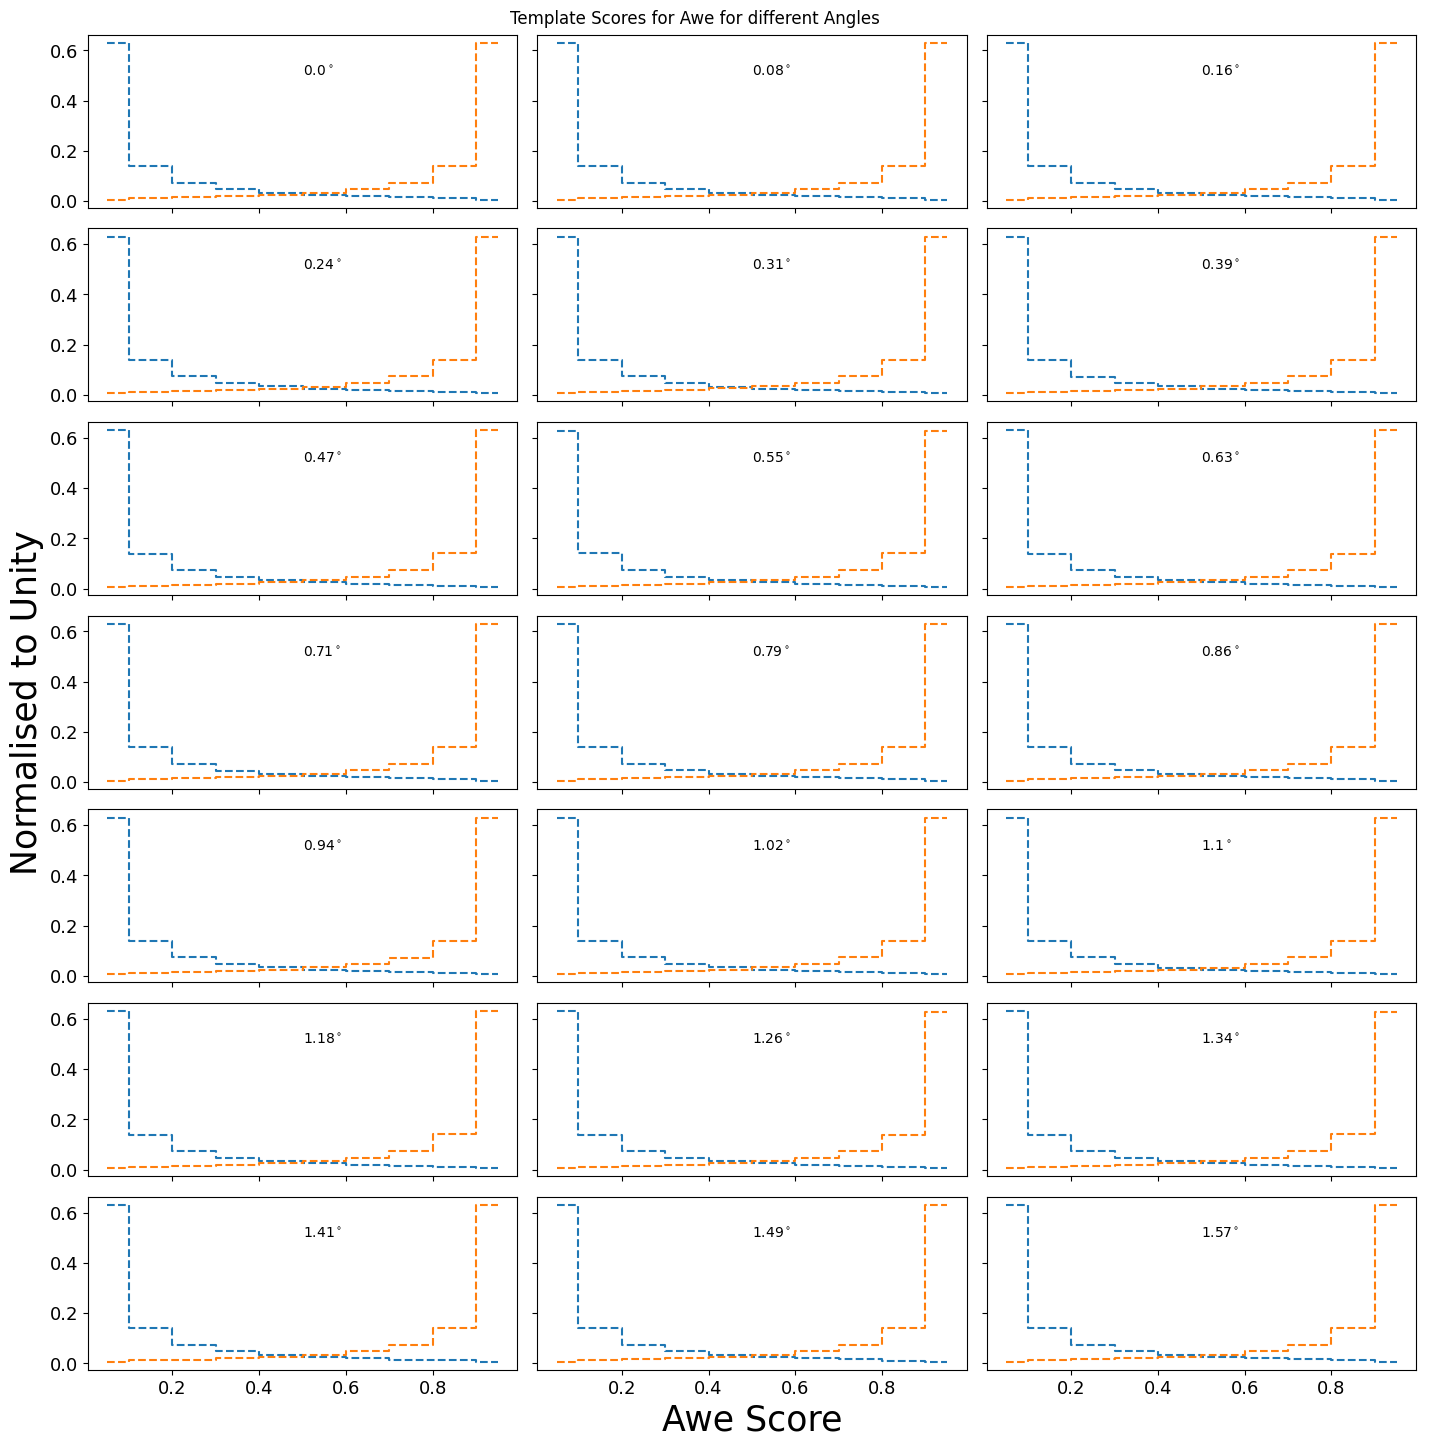

In [70]:
show_templates(sHists=sig_hists_awe,bHists=back_hists_awe,clfName="Awe")
#plt.savefig(plotDir + "TemplateHist_Awe_syst.pdf")
plt.show()

## Adversarially trained model

In [71]:
sig_hists_inv, back_hists_inv = buildTemplates(model=inv_model, clfName="Invariant")

5250/5250 [==============================] - 11s 2ms/step


In [72]:
hist_obs_inv, bin_array = createHistObs(X=X_syst_test[nominalEvents], weights=weights_syst[nominalEvents], 
              model=inv_model)

31231/31231 [==============================] - 14s 445us/step


In [73]:
if useAuxZMeasure:
    nll2D_inv_nom = computeNLL2D_aux(obs1D=hist_obs_inv, sH2d=sig_hists_inv, bH2d=back_hists_inv,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_inv_nom = computeNLL2D(obs1D=hist_obs_inv, sH2d=sig_hists_inv, bH2d=back_hists_inv)

nll1D_inv_nom = nll2D_inv_nom.min(axis=1)

Min at mu,z:  1.0 0.7853981633974483


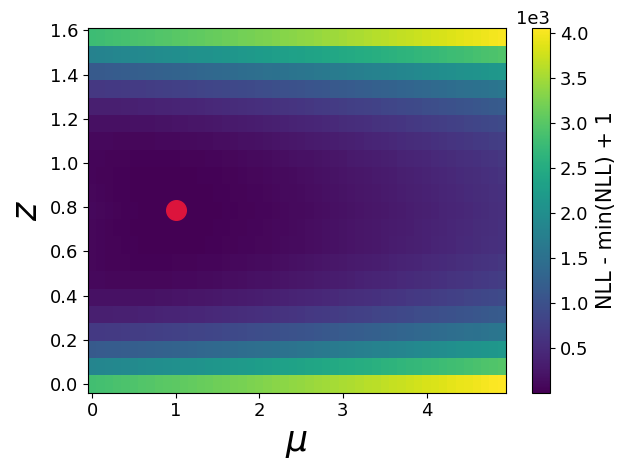

In [74]:
plot2dNLL(nll2D=nll2D_inv_nom, dataName="Nominal", clfName="Inv")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Inv", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

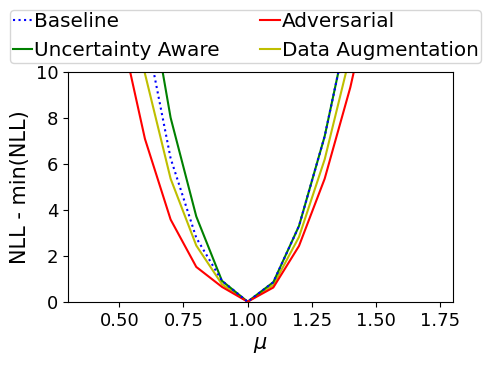

In [75]:
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_aug_nom-nll1D_aug_nom.min(), nll1D_awe_nom-nll1D_awe_nom.min(), 
                      nll1D_inv_nom-nll1D_inv_nom.min(), nll1D_clf_nom-nll1D_clf_nom.min()],
                label_list=["Data Augmentation", "Uncertainty Aware", "Adversarial","Baseline", ], 
                color_list=[augCol, aweCol, invCol,clfCol,], 
                linestyle_list=["solid", "solid", "solid", "dotted", ], 
              testDataLabel = "Nominal", ylimRatio=[0.75, 1.25], 
              legendOrder=[3,1,2,0], showLegend=True)
#plt.savefig(plotDir + "NLL_all_on_nominal.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

In [76]:
def ConfidenceIntervalls(mu_values, nll1D, central=1.0):
    z = np.polyfit(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1], 4)
    poly = np.poly1d(z)
    #1 Sigma = 0.5, 2 Sigma = 2, 3 Sigma = 4.5
    threshs = [0.5, 2.0, 4.5]
    sigmas = [1.0, 2.0, 3.0]
    ret_intersects = []
    std = 0.0
    
    for t,s  in zip(threshs, sigmas):
        intersects = (poly - t).roots
        # Select 2 roots closest to central value (only needed for polynomials with order > 2
        ret_intersects.append(intersects[np.argsort(np.abs(intersects-central))][:2])    
        std += (abs(ret_intersects[-1][0] - ret_intersects[-1][1])/(s*2))
        
    std = std/len(sigmas)
    
    #plt.plot(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1])
    #plt.plot(np.linspace(central-1,central+1, 100), poly(np.linspace(0,2, 100)))
    return std, ret_intersects
    
    
sigma_aug_nom, _ = ConfidenceIntervalls(mu_values=mu_values, nll1D=nll1D_aug_nom-nll1D_aug_nom.min())
sigma_awe_nom, _ = ConfidenceIntervalls(mu_values=mu_values, nll1D=nll1D_awe_nom-nll1D_awe_nom.min())
sigma_inv_nom, _ = ConfidenceIntervalls(mu_values=mu_values, nll1D=nll1D_inv_nom-nll1D_inv_nom.min())
sigma_clf_nom, _ = ConfidenceIntervalls(mu_values=mu_values, nll1D=nll1D_clf_nom-nll1D_clf_nom.min())


In [77]:
hist_obs_inv_systUp, bin_array = createHistObs(X=X_syst_test[systUpEvents], weights=weights_syst[systUpEvents], 
              model=inv_model)

31213/31213 [==============================] - 14s 452us/step


In [78]:
if useAuxZMeasure:
    nll2D_inv_systUp = computeNLL2D_aux(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_inv_systUp = computeNLL2D(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv)

nll1D_inv_systUp = nll2D_inv_systUp.min(axis=1)

Min at mu,z:  1.0 1.5707963267948966


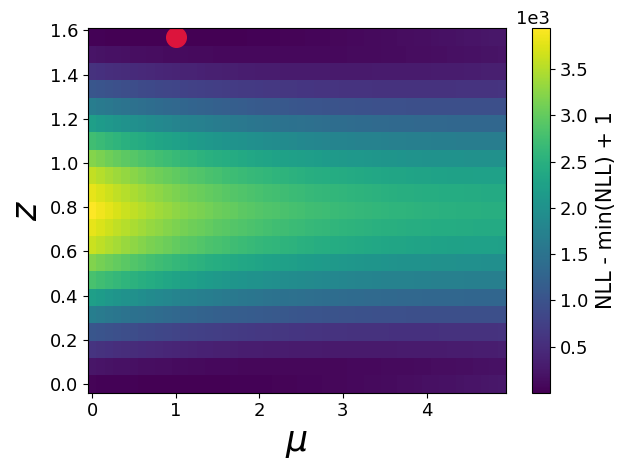

In [79]:
plot2dNLL(nll2D=nll2D_inv_systUp, dataName="SystUp", clfName="Inv") 
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Inv", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

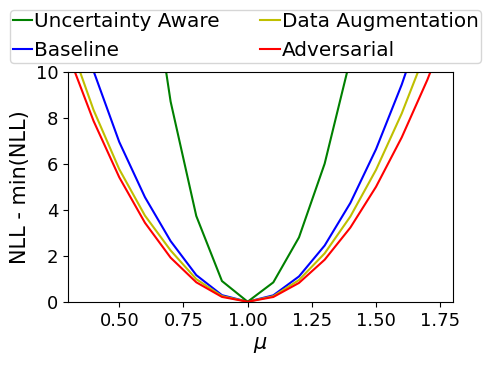

In [80]:
if useAuxZMeasure:
    lorder = [2,0,3,1] # number 2 corresponds to aware, number 0 corr to baseline, 1 to aug number 3 to inv
else:
    lorder = [2,0,1,3]
    
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_clf_systUp-nll1D_clf_systUp.min(), nll1D_aug_systUp-nll1D_aug_systUp.min(),
                      nll1D_awe_systUp-nll1D_awe_systUp.min(), nll1D_inv_systUp-nll1D_inv_systUp.min(),
                      ],
                label_list=[ "Baseline", "Data Augmentation", "Uncertainty Aware", "Adversarial" ], 
                color_list=[clfCol, augCol, aweCol,  invCol], 
                linestyle_list=["solid", "solid", "solid", "solid"], 
              testDataLabel = "systUp", ylimRatio=[0.75, 1.25],
             legendOrder=lorder, showLegend=True) # legend order tells you which plot should come first, then next, next, ...
#plt.savefig(plotDir + "NLL_all_on_systUp.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

# Coverage Tests


Generate 1000 pseudo experiments, using the same number of events as in the test sample (500k signal and 500k background, but scaled by the class weights of 0.1 and 0.001, resulting in 50k background and 500 signal events. 

As a crosscheck two versions of the data are generated, one in which the nuisance `z` parameter is fixed to the mean `z_nominal` (`X_sig_data_nom` etc.) and one where it is sampled from the prior, with every pseudo experiment having a different `z` that remains consistent for that experiment (`X_sig_data_samp` etc.)


In [81]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 



### Single experiment x1000 nominal z
n_data = 500000

n_exp = 100
n_data_nom = n_data

X_sig_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*sigScaling), 2))
Y_sig_data_nom = np.ones((n_exp, int(n_data_nom*sigScaling)))

Z_incarnation = np.array([z_nominal])
centres_sig_data_nom = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_nom += centres_sig_data_nom


X_back_data_nom = np.random.normal(0, feature_std, (n_exp, int(n_data_nom*backScaling), 2))
Y_back_data_nom = np.zeros((n_exp, int(n_data_nom*backScaling)))

centres_back_data_nom = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_nom += centres_back_data_nom

X_data_nom = np.concatenate([X_sig_data_nom,X_back_data_nom], 1)
Y_data_nom = np.hstack([Y_sig_data_nom,Y_back_data_nom])
Z_data_nom = np.zeros_like(Y_data_nom) + np.expand_dims(Z_incarnation, 1)

weights_data_nom = np.ones_like(Y_data_nom)
Y_predict_data_nom = nominal_model.predict(X_data_nom)




### Single experiment x1000 sampled z

n_data_samp = n_data

X_sig_data_samp = np.random.normal(0, feature_std, (n_exp, int(n_data_samp*sigScaling), 2))
Y_sig_data_samp = np.ones((n_exp, int(n_data_samp*sigScaling)))

Z_incarnation = np.random.normal(z_nominal, z_std, n_exp)
centres_sig_data_samp = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data_samp += centres_sig_data_samp


X_back_data_samp = np.random.normal(0, feature_std, (n_exp, int(n_data_samp*backScaling), 2))
Y_back_data_samp = np.zeros((n_exp, int(n_data_samp*backScaling)))

centres_back_data_samp = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data_samp += centres_back_data_samp


X_data_samp = np.concatenate([X_sig_data_samp,X_back_data_samp], 1)
Y_data_samp = np.hstack([Y_sig_data_samp,Y_back_data_samp])
Z_data_samp = np.zeros_like(Y_data_samp) + np.expand_dims(Z_incarnation, 1)

weights_data_samp = np.ones_like(Y_data_samp)
Y_predict_data_samp = nominal_model.predict(X_data_samp)


## Defining new template regions

The original template range did not cover a large enough `z` range to handle all the possible values when sampling from the Gaussian prior. This follows the previous code for setting up the data for the template generation, but extends the range

In [82]:

n_shifts_train = 51
syst_shifts_train = np.arange(-20,31)/10
z_syst_train =  z_nominal * syst_shifts_train



X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T 
              for i in range (n_shifts_train)])
Y_sig_syst_train = np.array([np.ones(n_data) for i in range (n_shifts_train)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_syst_train[i]), np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T
                        for i in range (n_shifts_train)])
Y_back_syst_train = np.array([np.zeros(n_data) for i in range (n_shifts_train)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_syst_train[i]), -np.sin(z_syst_train[i])]).T for i in range(n_shifts_train)])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])
Z_syst_train  = np.ones_like(Y_syst_train) * z_syst_train.reshape(-1,1)


X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
Y_syst_train = Y_syst_train.reshape(-1)
Z_syst_train = Z_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


Redefining the previous template functions to use the extended range instead of the previous range. 

In [83]:
mu_values1D = np.arange(0,50)/10



def buildTemplatesTrain(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    
    if not (clfName == "Aware"):
        if (clfName == "Invariant"):
            Y_pred_model = model.predict(X_syst_train, batch_size=4000).reshape(-1)
        elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
            if (clfName == "Augmented") and (~aug_NN):
                Y_pred_model = model.predict_proba(X_syst_train)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_train).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
    
    for z_val in z_syst_train:
        zEvents = np.isclose(Z_syst_train, z_val)

        if (clfName == 'Aware'):
            Y_pred_model = aware_model.predict([X_syst_train[zEvents],Z_syst_train[zEvents]]).reshape(-1)

            hist_sig, bin_array = np.histogram(
                Y_pred_model[Y_syst_train[zEvents]==1], 
                weights=weights_syst_train[zEvents][Y_syst_train[zEvents]==1], range=(0,1), bins=nBins)
            hist_back, bin_array = np.histogram(
                Y_pred_model[Y_syst_train[zEvents]==0], 
                weights=weights_syst_train[zEvents][Y_syst_train[zEvents]==0], range=(0,1), bins=nBins)    
            
        else:
            hist_sig, bin_array = np.histogram(
                Y_pred_model[zEvents &(Y_syst_train==1)], 
                weights=weights_syst_train[zEvents &(Y_syst_train==1)], range=(0,1), bins=nBins)
            hist_back, bin_array = np.histogram(
                Y_pred_model[zEvents &(Y_syst_train==0)], 
                weights=weights_syst_train[zEvents &(Y_syst_train==0)], range=(0,1), bins=nBins)

        sig_hists.append(hist_sig)
        back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists



Modifying the NLL scans to use the extended range and directly return the values for the nuisance parameter `z` and the signal rate `mu` with the lowest NLL

In [84]:
def computeNLL2D_returnMu(obs1D, sH2d, bH2d, mu_values=mu_values1D, z_syst_vals=z_syst):
    min_mu, min_z, minnll = 999,999,999999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst_vals):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    #print ("Min at mu,z: ",min_mu, min_z)
    return nll2D, min_mu, min_z
        
    
    
def computeNLL2D_aware_returnMu(obs2D, sH2d, bH2d, mu_values=mu_values1D, z_syst_vals=z_syst):
    min_mu, min_z, minnll = 999,999,999999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst_vals):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std) # @ToDo: can be moved outside loop
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    #print ("Min at mu,z: ",min_mu, min_z)
    return nll2D, min_mu, min_z
        
        
def createHistObsPredicted(weights, Y_pred,):
    hist_obs, bin_array = np.histogram(Y_pred.reshape(-1), weights=weights.reshape(-1), range=(0,1), bins=nBins)
    return hist_obs, bin_array

def createHistObsAwe(X, weights):
    hist_obs_awe2D = []
    for hyp_z in z_syst_train:
        Y = aware_model.predict([X, np.ones(X.shape[0]) * hyp_z],).reshape(-1)
        hist_obs_awe, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
        hist_obs_awe2D.append(hist_obs_awe)
    hist_obs_awe2D = np.array(hist_obs_awe2D)
    return hist_obs_awe2D

        



Running the NLL scan on each pseudo experiment, and saving the resulting signal rate `mu` for all of them.  This is done for both the nominal and sample nuisance parameter. 

In [85]:
sig_hists_clf, back_hists_clf = buildTemplatesTrain(model=nominal_model, clfName="Nominal")
sig_hists_awe, back_hists_awe = buildTemplatesTrain(model=nominal_model, clfName='Aware')

mus_clf_nom = []
mus_clf_samp = []
mus_awe_nom = []
mus_awe_samp = []
#print(sig_hists_awe)


j = 1
#for j in range(0,1):
for j in range(0, weights_data_samp.shape[0]):
    
    hist_obs_nom, bin_array_nom = createHistObsPredicted(weights=weights_data_nom[j:j+1], Y_pred=Y_predict_data_nom[j:j+1])
    hist_obs_samp, bin_array_samp = createHistObsPredicted(weights=weights_data_samp[j:j+1], Y_pred=Y_predict_data_samp[j:j+1])
    hist_obs_awe2D_nom = createHistObsAwe(X_data_nom[j:j+1], weights=weights_data_nom[j])
    hist_obs_awe2D_samp = createHistObsAwe(X_data_samp[j:j+1], weights=weights_data_samp[j])

    
    nll2D_clf_data_nom, min_mu_clf_nom, min_z_clf_nom = computeNLL2D_returnMu(obs1D=hist_obs_nom, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    nll2D_clf_data_samp, min_mu_clf_samp, min_z_clf_samp = computeNLL2D_returnMu(obs1D=hist_obs_samp, sH2d=sig_hists_clf, bH2d=back_hists_clf, z_syst_vals=z_syst_train)
    
    nll2D_awe_data_nom, min_mu_awe_nom, min_z_awe_nom = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_nom, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)
    nll2D_awe_data_samp, min_mu_awe_samp, min_z_awe_samp = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D_samp, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)

    print(hist_obs_awe2D_nom, sig_hists_awe, back_hists_awe)
    
    
    mus_clf_nom.append(min_mu_clf_nom)
    mus_clf_samp.append(min_mu_clf_samp)
    mus_awe_nom.append(min_mu_awe_nom)
    mus_awe_samp.append(min_mu_awe_samp)
    

    
    print(min_mu_awe_nom, min_z_awe_nom)
    




[[ 1090.  1379.  1635.  1890.  2199.  2673.  3545.  4960.  7998. 23131.]
 [ 1289.  1569.  1841.  2153.  2326.  2922.  3744.  5083.  8075. 21498.]
 [ 1512.  1861.  2099.  2286.  2585.  3167.  3927.  5191.  8088. 19784.]
 [ 1779.  2181.  2362.  2477.  2897.  3414.  4012.  5409.  7921. 18048.]
 [ 2167.  2544.  2545.  2880.  3165.  3517.  4199.  5435.  7787. 16261.]
 [ 2640.  2881.  2952.  3140.  3394.  3654.  4377.  5415.  7553. 14494.]
 [ 3189.  3341.  3350.  3383.  3522.  3867.  4470.  5318.  7331. 12729.]
 [ 3891.  3782.  3803.  3580.  3677.  4042.  4444.  5235.  6947. 11099.]
 [ 4687.  4415.  4035.  3795.  3956.  4036.  4446.  5082.  6477.  9571.]
 [ 5672.  4935.  4350.  4081.  4027.  4071.  4311.  4917.  6006.  8130.]
 [ 6794.  5479.  4653.  4267.  4054.  4065.  4194.  4673.  5482.  6839.]
 [ 8062.  6032.  4930.  4354.  4123.  3948.  4017.  4415.  4949.  5670.]
 [ 9475.  6510.  5156.  4395.  4085.  3855.  3887.  4026.  4341.  4770.]
 [11062.  6943.  5245.  4467.  3948.  3812.  3578. 

Plotting the resulting `mu` distributions for the nominal `z` value (red), and the sampled `z` value (green) and comparing it to a Gaussian distribution with a width and mean derived from the NLL profile (blue). For reference fits of Gaussian distributions to the histogram data are included, sharing a color with the histograms.

0.07248613660556066 0.07549927914830894
0.24761823438511146 0.07549927914830894


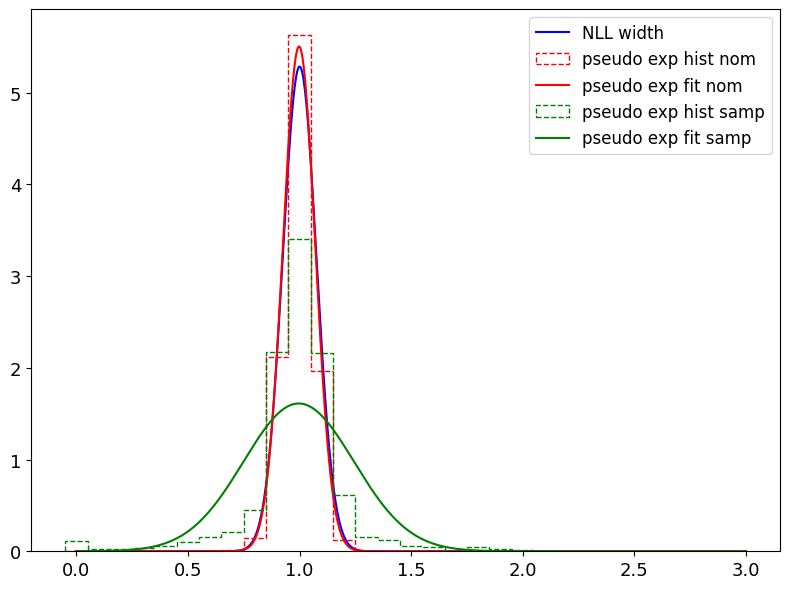

In [89]:
from scipy.stats import norm


fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom
print(np.std(mus_clf_nom), sigma_clf_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_nom))/np.std(mus_clf_nom)))/np.std(mus_clf_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_clf_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_clf_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom
print(np.std(mus_clf_samp), sigma_clf_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf_samp))/np.std(mus_clf_samp)))/np.std(mus_clf_samp)


subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


0.11864231959971112 0.0776790161708697
1.6083531950414376 0.0776790161708697


/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


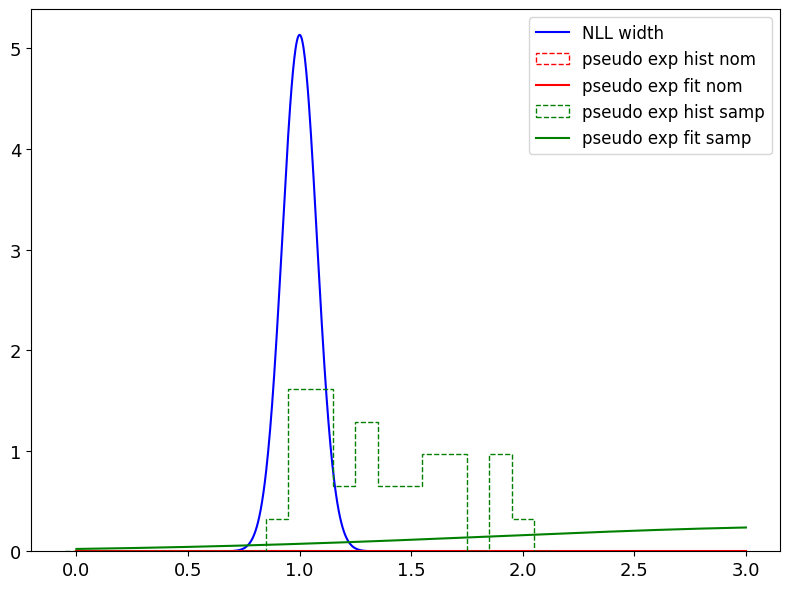

In [119]:

fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom
print(np.std(mus_awe_nom), sigma_awe_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_awe_nom))/np.std(mus_awe_nom)))/np.std(mus_awe_nom)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_awe_nom, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')




subplot.hist(mus_awe_samp, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist samp', histtype='step', color='g', ls='--')

y_gauss = (norm.pdf((x_gauss-1)/sigma_awe_nom))/sigma_awe_nom
print(np.std(mus_awe_samp), sigma_awe_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_awe_samp))/np.std(mus_awe_samp)))/np.std(mus_awe_samp)


subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit samp', color='g')
subplot.legend(fontsize=12)


In [ ]:
mus = np.array(mus)


cov_1sig = sum(abs(mus-1) < sigma_clf_samp)/n_exp
cov_2sig = sum(abs(mus-1) < sigma_clf_samp*2)/n_exp
cov_3sig = sum(abs(mus-1) < sigma_clf_samp*3)/n_exp

print('1 Sigma: {:.2f} \n'.format(cov_1sig) + 
      '2 Sigma: {:.2f} \n'.format(cov_2sig) + 
      '3 Sigma: {:.2f} '.format(cov_3sig))
    
    

